<a href="https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/day1/2_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression on CIFAR10

Now that we have seen how to load image data for classification and wrap it into a torch dataset, we will go ahead and train "simple" classiification models useing torch.
In this notebook, we will start with [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)
that learns to classifiy the images based on the pixel values and then continue with a model trained on "hard-coded" convolutional features.

In [1]:
# load tensorboard extension
%load_ext tensorboard

In [2]:
# import torch and other libraries
import os
import numpy as np
import torch
import torch.nn as nn
import sklearn.metrics as metrics

In [3]:
# check if we have gpu support.
# colab offers free gpus, however they are not activated by default.
# to activate the gpu, go to 'Runtime->Change runtime type'. 
# Then select 'GPU' in 'Hardware accelerator' and click 'Save'
have_gpu = torch.cuda.is_available()
# we need to define the device for torch, yadda yadda
if have_gpu:
    print("GPU is available")
    device = torch.device('cuda')
else:
    print("GPU is not available, training will run on the CPU")
    device = torch.device('cpu')

GPU is not available, training will run on the CPU


In [ ]:
# run this in google colab to get the utils.py file
!wget https://raw.githubusercontent.com/constantinpape/training-deep-learning-models-for-vison/master/day1/utils.py 

In [4]:
import utils

In [27]:
cifar_dir = './cifar10'
categories = os.listdir('./cifar10/train')
categories.sort()
!cifar2png cifar10 cifar10

output dir `cifar10` already exists. Please specify a different output path


## Prepare the data

We have already seen how to create a torch dataset for the cifar dataset in the previous notebook. We will repeat this here, but now split our data into training and validation data beforehand  

In [7]:
images, labels = utils.load_cifar(os.path.join(cifar_dir, 'train'))

100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


In [8]:
# shuffle the data, split into training and validation set

# shuffle the data
n_images = len(images)
indices = np.arange(n_images)
np.random.shuffle(indices)

# split into training and validation data
validation_fraction = 0.15
split_index = int(validation_fraction * n_images)
train_indices = indices[:-split_index]
val_indices = indices[-split_index:]

train_images, val_images = images[train_indices], images[val_indices]
train_labels, val_labels = labels[train_indices], labels[val_indices]
assert len(train_images) == len(train_labels)
assert len(val_images) == len(val_labels)
assert len(train_images) + len(val_images) == n_images

print("Split cifar into training and validation data:")
print("Have", len(train_images), "training images and", len(val_images), "validation images")

Split cifar into training and validation data:
Have 42500 training images and 7500 validation images


In [9]:
# create the torch datasets for training and validation
from functools import partial

trafos = [utils.to_channel_first, utils.normalize, utils.to_tensor]
trafos = partial(utils.compose, transforms=trafos)

train_dataset = utils.DatasetWithTransform(train_images, train_labels,
                                           transform=trafos)

val_dataset = utils.DatasetWithTransform(val_images, val_labels,
                                         transform=trafos)

## Training and validation function

Now write the function that runs training and validation for 1 epoch.
Epoch: training model on the training set once.
Important: we want to monitor the progress during the training -> tensorboard.

In [18]:
# this is the training function.
# don't be scared by the many arguments, a lot of this is just
# for logging, and we explain it in more detail in the
# training procedure
def train(model, loader, 
          loss_function, optimizer,
          device, epoch,
          tb_logger, log_image_interval=20):
    """ Train model for one epoch.
    
    Parameters:
    model - 
    loader - 
    loss_function - 
    optimizer - 
    device - 
    epoch -
    tb_logger - 
    log_image_interval -
    """

    # set model to train mode
    model.train()
    
    # iterate over the training batches provided by the loader
    n_batches = len(loader)
    for batch_id, (x, y) in enumerate(loader):
       
        # send tensors to the active device
        x.to(device), y.to(device)
        
        # set the gradients to zero, to start with "clean" gradients
        # in this training iteration
        optimizer.zero_grad()
        
        # apply the model and get our prediction
        prediction = model(x)
        
        # FIXME collate in dataloader is annoying here
        # calculate the loss (negative log likelihood loss)
        loss_value = loss_function(prediction, y[:, 0])
        
        # calculate the gradients (`loss.backward()`) 
        # and apply them to the model weights (`optimizer.ste()`)
        loss_value.backward()
        optimizer.step()
        
        step = epoch * n_batches + batch_id
        tb_logger.add_scalar(tag='train-loss', 
                             scalar_value=loss_value.item(),
                             global_step=step)
        # TODO add the prediction and label here
        if log_image_interval is not None and step % log_image_interval == 0:
            tb_logger.add_images(tag='input', 
                                 img_tensor=x.to('cpu'),
                                 global_step=step)

In [19]:
# yadda yadda
def validate(model, loader, loss_function, 
             device, step, tb_logger=None):
    """
    Validate the model predictions after a training epoch.
    
    Arguments:
    model
    """
    # 
    model.eval()
    
    n_batches = len(loader)
    n_samples = len(loader.dataset)
   
    mean_loss = 0
    predictions = []
    labels = []
    
    with torch.no_grad():
        for x, y in loader:
            x.to(device), y.to(device)
            prediction = model(x)
            # FIXME collate in dataloader is annoying
            mean_loss += loss_function(prediction, y[:, 0]).item()
    
            # compute the most likely class predictions
            prediction = prediction.max(1, keepdim=True)[1]

            # store the predictions
            predictions.append(prediction[:, 0].numpy())
            labels.append(y[:, 0].numpy())
        
    predictions = np.concatenate(predictions)
    labels = np.concatenate(labels)
    
    if tb_logger is not None:
        
        accuracy_error = 1. - metrics.accuracy_score(labels, predictions)
        mean_loss /= n_batches
        
        tb_logger.add_scalar(tag="validation-error",
                             global_step=step,
                             scalar_value=accuracy_error)
        tb_logger.add_scalar(tag="validation-loss",
                             global_step=step,
                             scalar_value=mean_loss)

    # return all predictions and labels for further evaluation
    return predictions, labels

## Model

different ways to define models, inherit from `torch.nn.Module`,
define forward pass via method `forward`, yadda yadda

In [11]:
# define logistic regression model
class LogisticRegressor(nn.Module):
    def __init__(self, n_pixels, n_classes):
        super().__init__()
        self.n_pixels = n_pixels
        self.n_classes = n_classes
        self.log_reg = nn.Sequential(nn.Linear(self.n_pixels,
                                               self.n_classes),
                                     nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        # reshape the input to be 1d instead of 2d,
        # which is required for fully connected layers
        x = x.view(-1, self.n_pixels)
        x = self.log_reg(x)
        return x

## Set up the training

Now it's time to bring everything together:

In [12]:
n_pixels = images[0].size  # number of pixels = 3 * 32 * 32
n_classes = 10    
model = LogisticRegressor(n_pixels, n_classes)
model.to(device)

LogisticRegressor(
  (log_reg): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [13]:
# create data loader
# what is this yadda yadda
from torch.utils.data import DataLoader
batch_size = 2
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size, 
                          shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=10)

In [14]:
# create optimizer
# what is this yadda yadda
from torch.optim import Adam
optimizer = Adam(model.parameters())

In [15]:
# create loss
# what is this yadda yadda
loss_function = nn.NLLLoss()
loss_function.to(device)

NLLLoss()

In [18]:
# clear the tensorboard logs
from shutil import rmtree
rmtree('runs/log_reg')

FileNotFoundError: [Errno 2] No such file or directory: 'runs/log_reg'

In [16]:
# explain tensorboard
from torch.utils.tensorboard import SummaryWriter
tb_logger = SummaryWriter('runs/log_reg')
%tensorboard --logdir runs

In [20]:
from tqdm import trange
n_epochs = 4
for epoch in trange(n_epochs):
    train(model, train_loader, loss_function, optimizer,
          device, epoch, tb_logger=tb_logger)
    step = (epoch + 1) * len(train_loader)
    validate(model, val_loader, loss_function,
             device, step,
             tb_logger=tb_logger)

100%|██████████| 4/4 [02:19<00:00, 34.93s/it]


## Check the model on test data

TODO need to check everything on test data!
confusion matrix

In [21]:
test_images, test_labels = utils.load_cifar(os.path.join(cifar_dir, 'test'))

100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


In [22]:
test_dataset = utils.DatasetWithTransform(test_images, test_labels,
                                          transform=trafos)
test_loader = DataLoader(test_dataset, batch_size=25)

Test accuracy
0.2782

Test confusion matrix


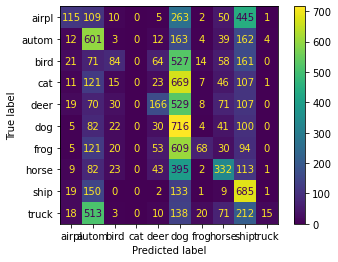

In [29]:
test_predictions, test_labels = validate(model, test_loader, loss_function,
                                         device, 0, tb_logger=None)
accuracy = metrics.accuracy_score(test_labels, test_predictions)
print("Test accuracy")
print(accuracy)
print()
cmatrix = metrics.confusion_matrix(test_labels, test_predictions)
# make it pretty
print("Test confusion matrix")
categories_short = [category[:5] for category in categories]
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cmatrix,
                                      display_labels=categories_short)
disp.plot()

## Logistic Regression with preset filters

In [29]:
# write this as a function that takes 
def apply_filters(image, target, filter_list, keep_image=False):    
    filtered = [image] if keep_image else [] 
    for filter_function in filter_list:
        filtered.append(filter_function(image))
    data = np.concatenate(filtered, axis=-1)
    return data, target

In [31]:
import skimage.filters as filters

# simple filter training
filter_list = [filters.gaussian]
blur_filter = partial(apply_filters,
                      filter_list=filter_list,
                      keep_image=True)

trafos = [
    blur_filter,
    utils.normalize,
    utils.to_channel_first,
    utils.to_tensor
]
trafos = partial(utils.compose, transforms=trafos)

train_dataset = utils.DatasetWithTransform(train_images, train_labels,
                                           transform=trafos)

val_dataset = utils.DatasetWithTransform(val_images, val_labels,
                                         transform=trafos)

In [32]:
batch_size = 4
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size, 
                          shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=10)

In [34]:
n_pixels = 6 * 32 * 32  # number channels * number pixels
n_classes = 10    
model = LogisticRegressor(n_pixels, n_classes)
model.to(device)

optimizer = Adam(model.parameters())

tb_logger = SummaryWriter('runs/log_reg_filters1')

n_epochs = 4
for epoch in trange(n_epochs):
    train(model, train_loader, loss_function, optimizer,
          device, epoch, tb_logger=tb_logger, log_image_interval=None)
    step = (epoch + 1) * len(train_loader)
    validate(model, val_loader, loss_function, device, step,
             tb_logger=tb_logger)

  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-29-94a7f6c16c16>:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  filtered.append(filter_function(image))
100%|██████████| 4/4 [02:29<00:00, 37.29s/it]


## Tasks and Questions:

Questions:
- What accuracy do the different models reach?
- Which accuracy do you expect by guessing?
- Other metrics than accuracy / confusion table?

Tasks:
- Try more filters, compare the different models via tensorboard and on the test dataset.
- Filters can be expressed as torch convolutions! Do this for torch.gaussian and train a model with this for different degrees of smoothing. How does it perform? (Give a hint!)
- Advanced can you do it for other convolutional filters?